# Image2Gloss

Кирилл Конча, Максим Бажуков

Проект по переводу картинок с глоссами в формат LaTeX.

Используется Seq2Seq архитектура (Convolutional Ecnoder).



Репозиторий с архитектурой сети

In [ ]:
!git init
!git remote add origin https://github.com/tuanio/image2latex
!git pull origin main

In [ ]:
!pip install opencv-python

In [ ]:
!pip install albumentations

In [ ]:
!pip install -r requirements.txt > out.txt

Добавим аугментации к картинкам в их загрузчик (data/dataset.py*).

In [97]:
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch
import torchvision
from torchvision import transforms as tvt
import math
import os
import random
import cv2
import numpy as np
import albumentations as A

transform_aug = A.Compose([

    A.OneOf([
      #add black pixels noise
      A.OneOf([
             #A.RandomRain(brightness_coefficient=1.0, drop_length=1, drop_width=1, drop_color = (0, 0, 0), blur_value=0.8, rain_type = 'drizzle', p=0.05),
              #A.RandomShadow(p=0.5),
              A.PixelDropout(p=0.3),
         ], p=0.7),

      #add white pixels noise
      A.OneOf([
              A.PixelDropout(dropout_prob=0.3,drop_value=255,p=1),
             #A.RandomRain(brightness_coefficient=1.0, drop_length=1, drop_width=1, drop_color = (255, 255, 255), blur_value=1, rain_type = None, p=1),
        ], p=0.7),
    ], p=1),

  ])

Примеры аугментаций

In [70]:
import random
import cv2
import numpy as np
import albumentations as A
from PIL import Image

#gets PIL image and returns augmented PIL image
def augment_img(img):
  #only augment 3/4th the images
  if random.randint(1, 4) > 3:
      return img

  img = np.asarray(img)     #convert to numpy for opencv

  # morphological alterations
  kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
  if random.randint(1, 5) == 1:
    # dilation because the image is not inverted
    img = cv2.erode(img, kernel, iterations=random.randint(1, 1))
  if random.randint(1, 6) == 1:
    # erosion because the image is not inverted
    img = cv2.dilate(img, kernel,iterations=random.randint(1, 1))

  transform = A.Compose([

    A.OneOf([
      #add black pixels noise
      A.OneOf([
             #A.RandomRain(brightness_coefficient=1.0, drop_length=1, drop_width=1, drop_color = (0, 0, 0), blur_value=0.8, rain_type = 'drizzle', p=0.05),
              #A.RandomShadow(p=0.5),
              A.PixelDropout(p=0.3),
         ], p=0.7),

      #add white pixels noise
      A.OneOf([
              A.PixelDropout(dropout_prob=0.3,drop_value=255,p=1),
             #A.RandomRain(brightness_coefficient=1.0, drop_length=1, drop_width=1, drop_color = (255, 255, 255), blur_value=1, rain_type = None, p=1),
        ], p=0.5),
    ], p=1),
  ])
  # try-except, потому что как оказалось не все аугментации можно применить к нашим картинкам (с пустым фоном)
  #try:
  img = transform(image=img)['image']
  #except ValueError:
  #  img = img
  image = Image.fromarray(img)
  return image

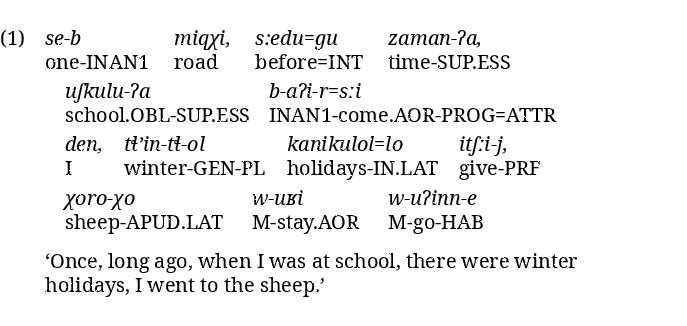

In [87]:
augment_img(img)

Логин в wandb

In [3]:
#!wandb login <my-token>

/bin/bash: wandb: command not found


Смонтируем гугл-диск, чтобы выкачать данные. Данные доступны по [ссылке](https://drive.google.com/drive/folders/19uYJ3B2hIeEGdkz2Q_6FzuLUL8WkrAeI).

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Скопируем датасет

In [5]:
!cp -r /content/drive/MyDrive/project /content

Конвертация картинок в jpg

In [72]:
from PIL import Image

images = glob.glob("/content/project/png/*png")
try:
  os.mkdir("/"+images[0].split("/")[1]+"/jpg")
except FileExistsError:
  pass
for im in images:
  img = Image.open(im)
  img = img.convert('RGB')
  img.save("/"+images[0].split("/")[1]+"/jpg/"+os.path.basename(im.replace("png", "jpg")))

In [62]:
"/"+images[0].split("/")[1]

'/content'

In [74]:
import pandas as pd
import glob
import os

images = glob.glob("/content/jpg/*jpg")
paths = []
formulas = []

for im in images:
  paths.append(os.path.basename(im))
  with open(os.path.join("/content/project/tex", os.path.basename(im).replace("jpg", "tex"))) as f:
    data = f.readlines()
    data = " ".join(data)
    data = data.replace("\n", "")
  formulas.append(data)

df = pd.DataFrame({"formula": formulas, "image": paths})

In [68]:
df = pd.read_csv("/content/project/im2expex.csv")

In [70]:
df.head()

,formula,image


In [83]:
from sklearn.model_selection import train_test_split

test, train = train_test_split(df, test_size=0.2,train_size=0.8)
test, val = train_test_split(test, test_size = 0.5, train_size =0.5)

In [84]:
train.to_csv("im2latex_train.csv")
test.to_csv("im2latex_test.csv")
val.to_csv("im2latex_validate.csv")

In [77]:
import re

TOKENIZE_PATTERN = re.compile("(\\\\[a-zA-Z]+)|"+ # \[command name]
                              #"(\{\w+?\})|"+ # {[text-here]} Check if this is needed
                              "((\\\\)*[$-/:-?{-~!\"^_`\[\]])|"+ # math symbols
                              "(\w)|"+ # single letters or other chars
                              "(\\\\)") # \ characters

def tokenize_formula(formula):
    """Returns list of tokens in given formula.
    formula - string containing the LaTeX formula to be tokenized
    Note: Somewhat work-in-progress"""
    # Tokenize
    tokens = re.finditer(TOKENIZE_PATTERN, formula)
    # To list
    tokens = list(map(lambda x: x.group(0), tokens))
    # Clean up
    tokens = [x for x in tokens if x is not None and x != ""]
    return tokens

In [79]:
s = set()

def merge(x):
    global s
    s |= set(tokenize_formula(x))

df.formula.map(merge)

0      None
1      None
2      None
3      None
4      None
       ... 
117    None
118    None
119    None
120    None
121    None
Name: formula, Length: 122, dtype: object

Сохраним файл в json, переименуем в 100k_vocab.json и положим в data/vocab

In [80]:
import json

json.dump(['<p>', '<s>', '<e>'] + list(s), open('latex_tokens.json', 'w'))

In [92]:
import gc
torch.cuda.empty_cache()
gc.collect()

2593

Запустим обучение

In [93]:
%run main.py --batch-size 1 --accumulate-batch 1 --train --log-step 1 \
--train-sample 0 --test-sample 0 --val-sample 0 --num-workers 2 \
--max-epochs 8 --lr 0.01 --model-name conv_bilstm_lstm(new_1) --enc-type conv_row_encoder \
--enc-dim 256 --dec-dim 256 --emb-dim 40 --attn-dim 256 --dropout 0.1 \
--decode-type beamsearch --beam-width 3 --grad-clip 0 --dataset 100k \
--img-path /content/jpg \
--data-path /content

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


==========[Train]==========


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Image2Latex      | 7.3 M 
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
7.3 M     Trainable params
0         Non-trainable params
7.3 M     Total params
29.046    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.


Запустим тест

In [94]:
%run main.py --batch-size 1 --accumulate-batch 1 --test --log-step 1 \
--train-sample 0 --test-sample 0 --val-sample 0 --num-workers 2 \
--max-epochs 8 --lr 0.01 --model-name conv_bilstm_lstm(new_1) --enc-type conv_row_encoder \
--enc-dim 256 --dec-dim 256 --emb-dim 40 --attn-dim 256 --dropout 0.1 \
--decode-type beamsearch --beam-width 3 --grad-clip 0 --dataset 100k \
--img-path /content/jpg \
--data-path /content

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


==========[Test]==========


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Truth: [\documentclass [ p r e v i e w ] { s t a n d a l o n e } \usepackage [ e n g l i s h , r u s s i a n ] { b a b e l } \usepackage { f o n t s p e c } \usepackage { n o t o } \usepackage { c o l o r } \pagecolor { w h i t e } \usepackage { e x p e x } \begin { d o c u m e n t } \begin { m i n i p a g e } { . 9 \textwidth } \begin { c e n t e r } \ex \begingl \gla ū m b u - č i - ɣ ə t č - ē r i i s u - i - č i / / \glb у д и т ь - I m p f - C o n v A n t - R e f l . P l в е р н у т ь с я - P r s - T p l / / \glft ` П о р ы б а ч и в , ( о н и ) в о з в р а щ а ю т с я / / \endgl \xe \end { c e n t e r } \end { m i n i p a g e } \end { d o c u m e n t }] | Predict: [8 ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä ä]

Truth: [\documentc

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_bleu4         │            0.0            │
│    test_edit_distance     │    0.9994256496429443     │
│     test_exact_match      │            0.0            │
│         test_loss         │     5.232338905334473     │
└───────────────────────────┴───────────────────────────┘

К сожалению, результаты теста не вышли впечатляющими. Однако, стоит отметить ряд возможных причин почемк так произошло:

1) Первая и самая очевиденая -- недостаток данных. По сравнению со 100к формулами в латехе, у нас нет и близко подобного количества. Однако в теории, его можно вытащить из лингвистических статей в латехе используя регулярные выражения

2) Малое количество эпох: из-за того, что мы едва успевали сделать проект, не было времени обучить датасет на большем количестве эпох (например, в исходном репозитории обучение было на 30 эпохах, что во много раз больше чем 8 эпох)

3) Аугментации -- не всегда хорошо, и они могли помешать в распозновании символов. Мы добавляли аугментации, потому что в идеале хотели, чтобы с помощью нашего проекта можно было парсить глоссы из отсканированных книг